In [1]:
!pip install pycaret --target=/kaggle/working/pycaret

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/eb/43/ec8d59a663e0a1a67196b404ec38ccb0051708bad74a48c80d96c61dd0e5/pycaret-3.2.0-py3-none-any.whl.metadata
  Using cached pycaret-3.2.0-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for category-encoders>=2.4.0 from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Obtaining dependency information for imbalanced-learn>=0.8.1 from https://files.pythonhoste

In [2]:
# only needed for development purposes
import sys
sys.path.append('/kaggle/working/pycaret')

# basic libs
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# for preprocessing the data
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, FunctionTransformer, StandardScaler

# for model selection & training

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.model_selection import KFold, cross_val_score
from pycaret.regression import *

In [3]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# 0. Data Analysis

In [4]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
df_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


## I. Concat data sets

In [8]:
# concatenated data sets will ease analysis

df_combined = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df_combined.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [9]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [10]:
# wrong type allocation
#df_combined['MSSubClass'] = df_combined['MSSubClass'].astype('O')

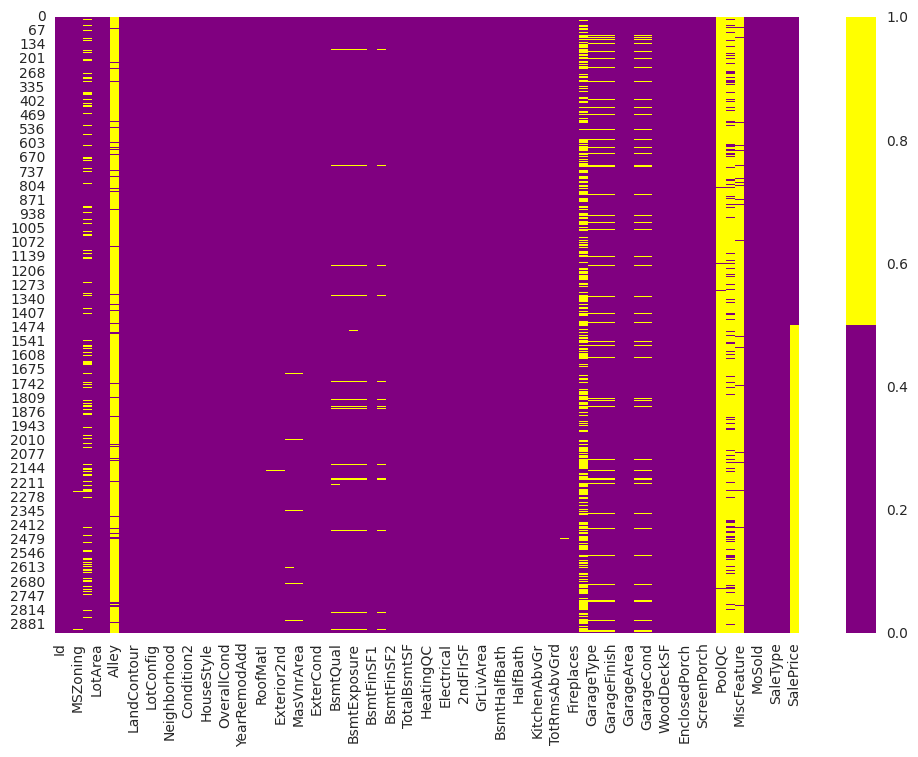

In [11]:
plt.figure(figsize=(12,8))
_ = sns.heatmap(df_combined.isnull(), cmap=sns.color_palette(['purple', 'yellow']))

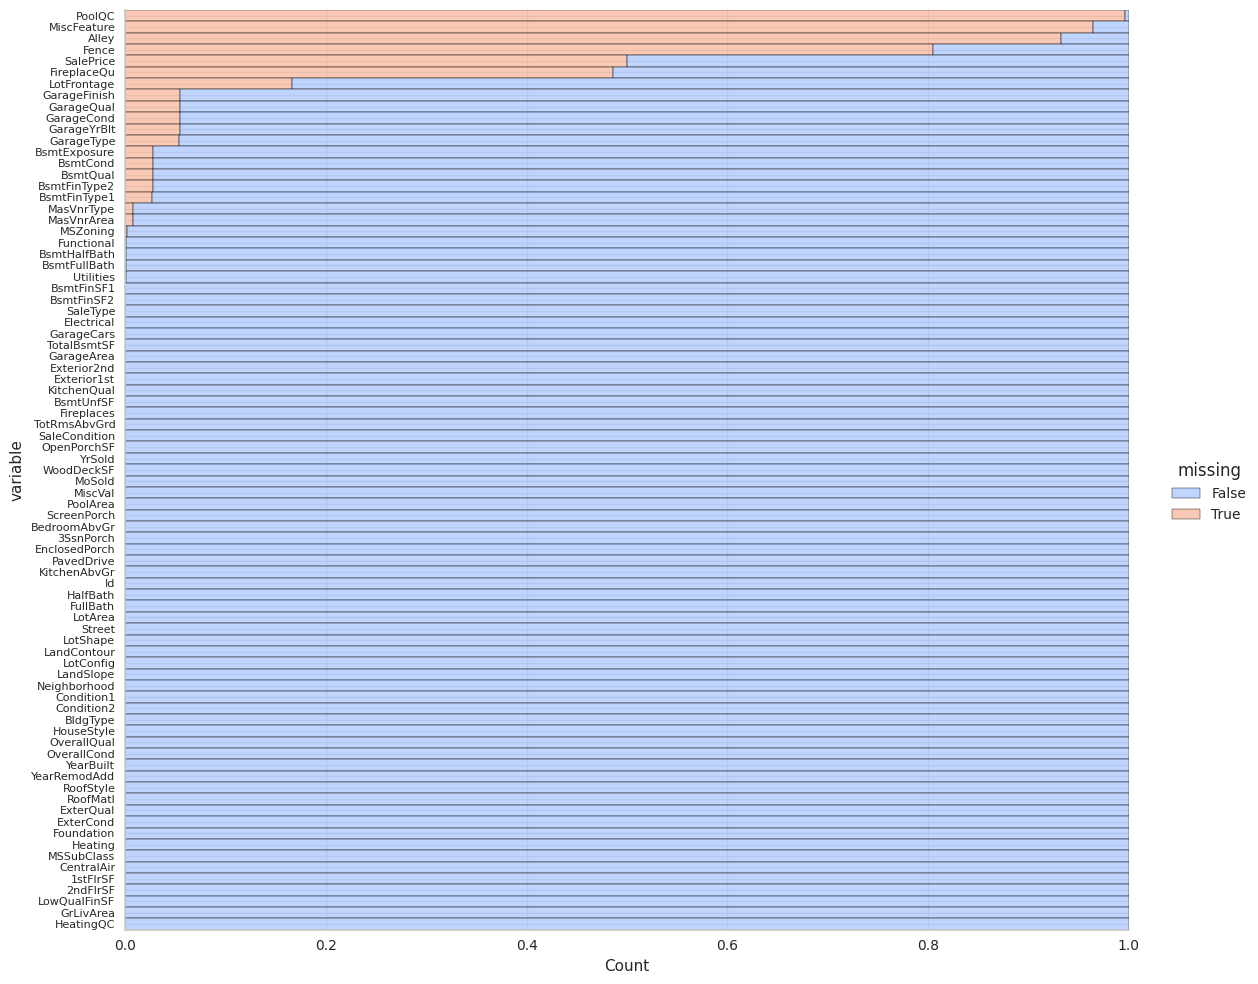

In [12]:
# Sort the DataFrame by the sum of missing values in descending order
df_sorted = df_combined.isnull().sum(axis=0).sort_values(ascending=False).index
df_melted = df_combined.isnull()[df_sorted].melt(value_name='missing')

# Create the displot using the melted DataFrame
ax = sns.displot(
    data=df_melted,
    y='variable',
    hue='missing',
    multiple='fill',
    height=10,
    aspect=1.2,
    palette='coolwarm'
)

ax.set_yticklabels(fontsize=8)
plt.show()

In [13]:
na_features = df_combined.columns[(df_combined.isna().sum() > 0)]
df_combined[na_features].isna().sum().sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

In [14]:
num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_include=object)

In [15]:
na_features_categorical = cat_selector(df_combined[na_features])
na_features_numerical = num_selector(df_combined[na_features])

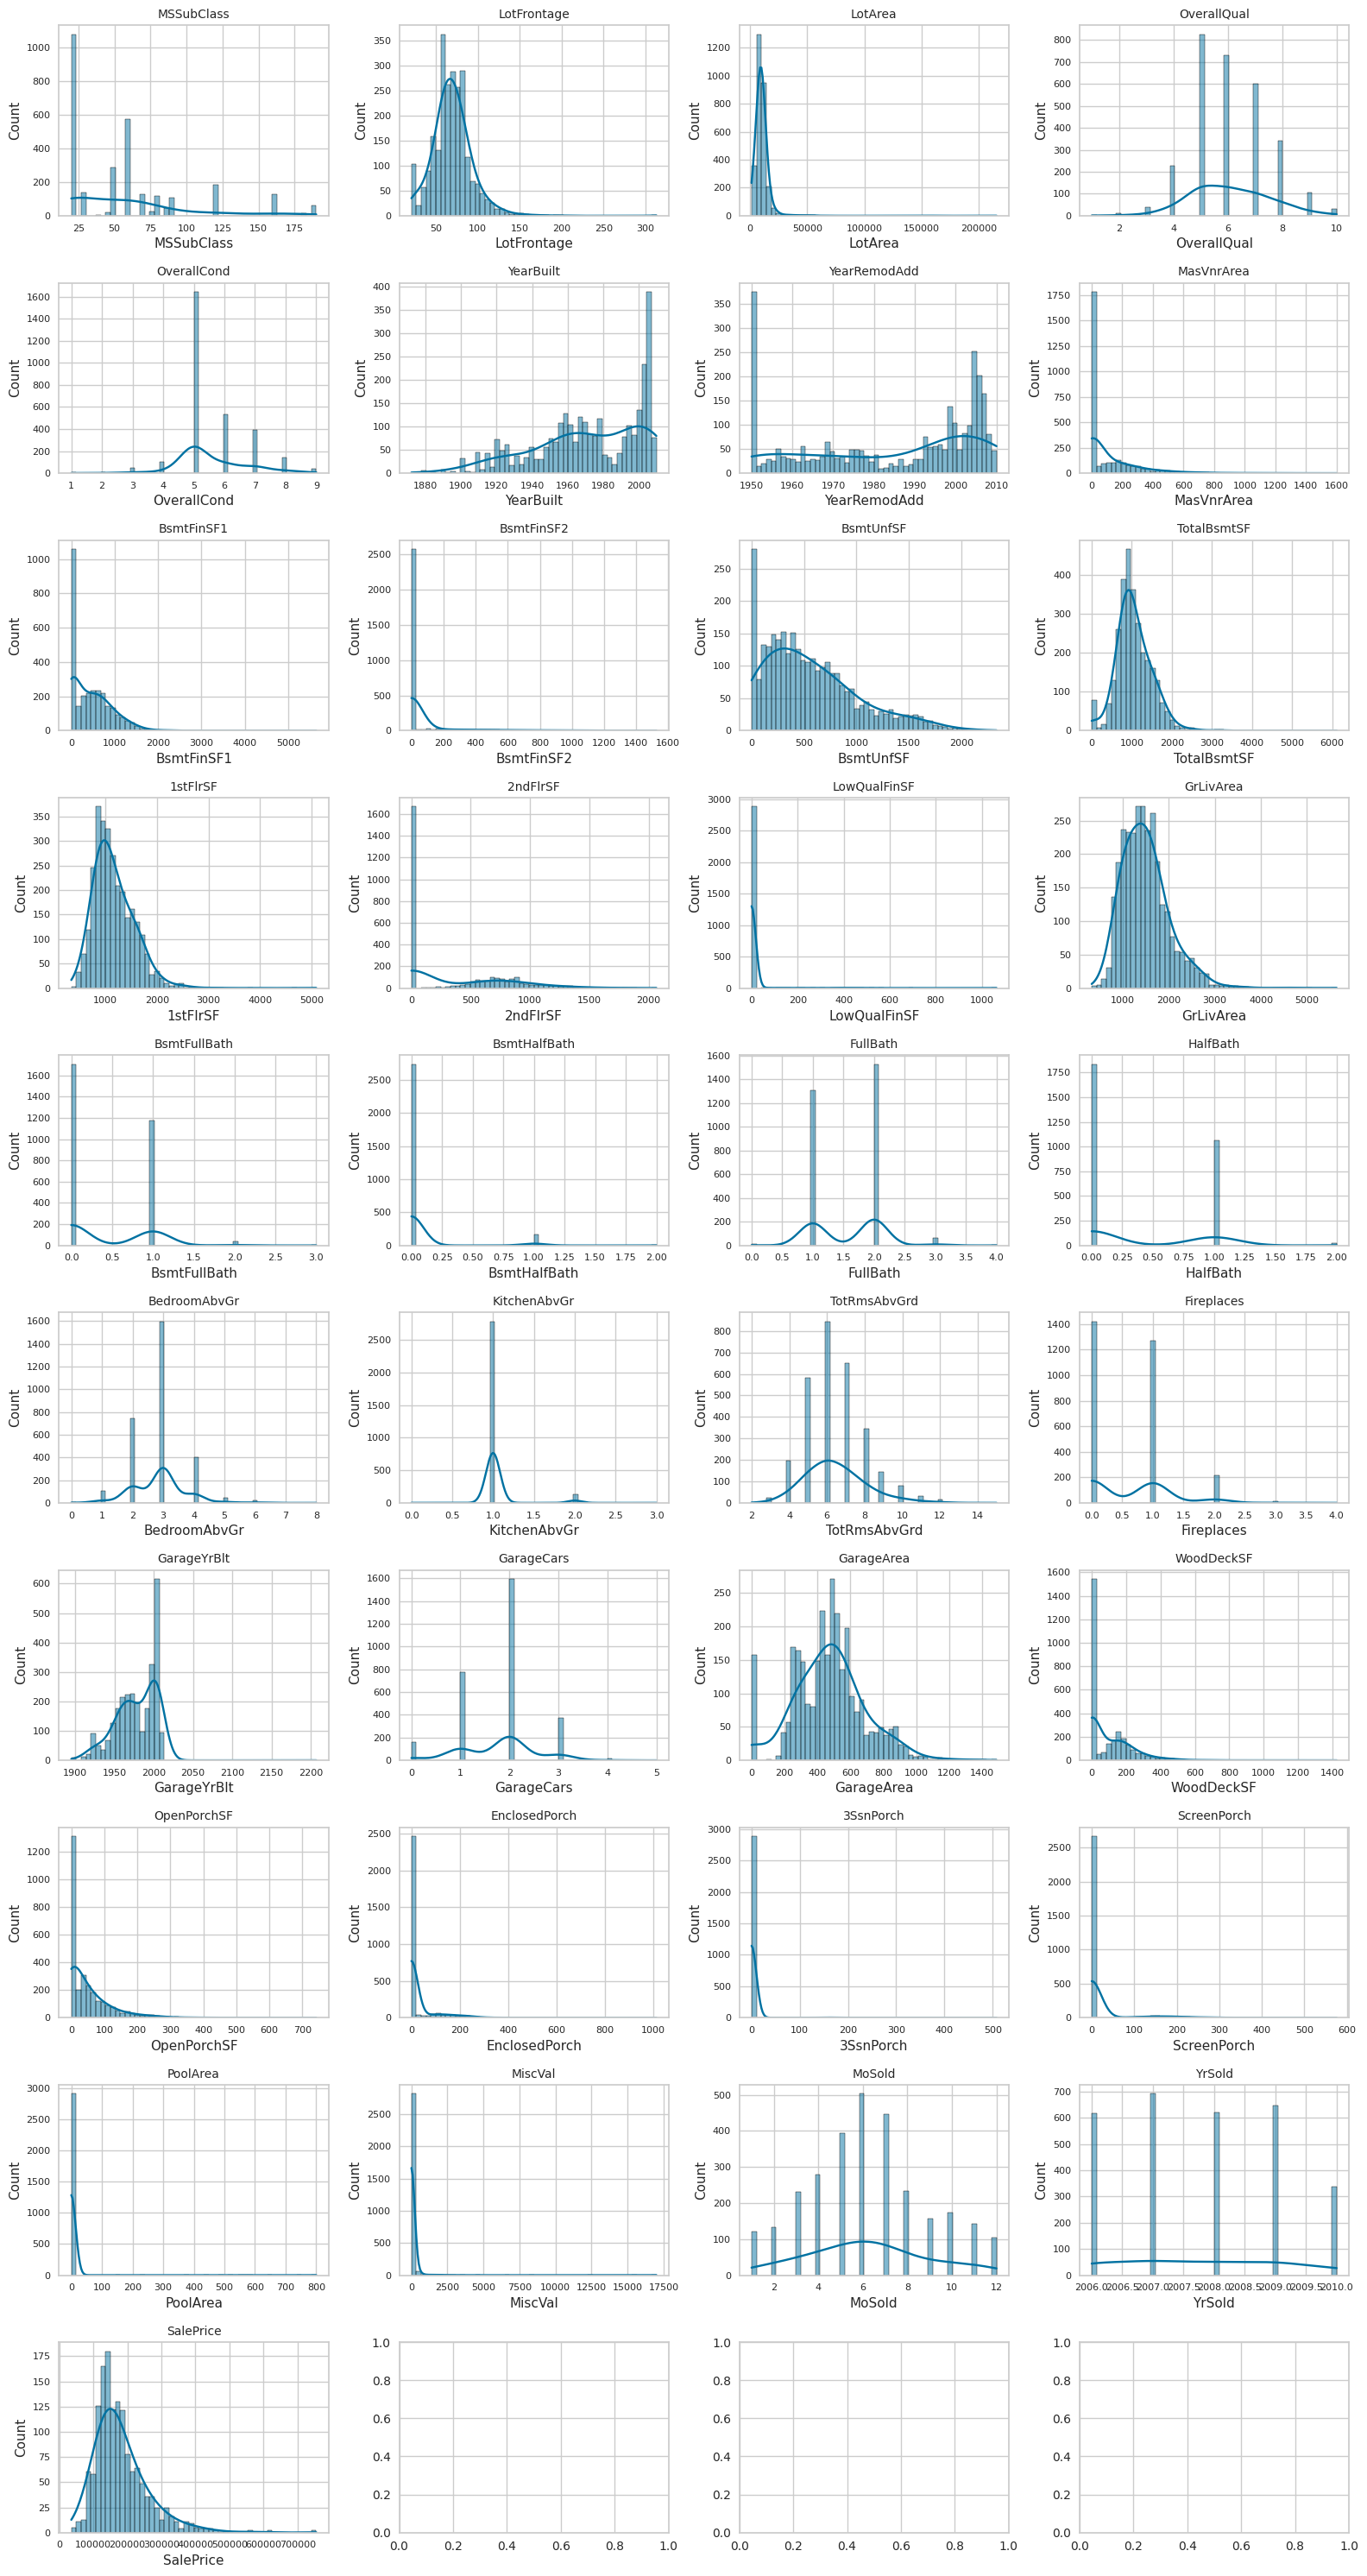

In [16]:
# Drop 'Id' column
df_combined_no_id = df_combined[num_selector(df_combined)].drop('Id', axis=1)

# Calculate the number of rows and columns for subplots
num_cols = df_combined_no_id.shape[1]
num_rows = math.ceil(num_cols / 4)  # Adjust the divisor based on your layout preference

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 3 * num_rows))
axes = axes.flatten()[:num_cols]  # Flatten the 2D array of subplots and truncate to match the number of columns

# Iterate through each column and plot a histogram
# add a KDE and smooth it
for i, column in enumerate(df_combined_no_id.columns):
    sns.histplot(df_combined_no_id[column], bins=50, ax=axes[i], kde=True, kde_kws={'bw_adjust':2, 'cut':0})
    axes[i].set_title(column, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()


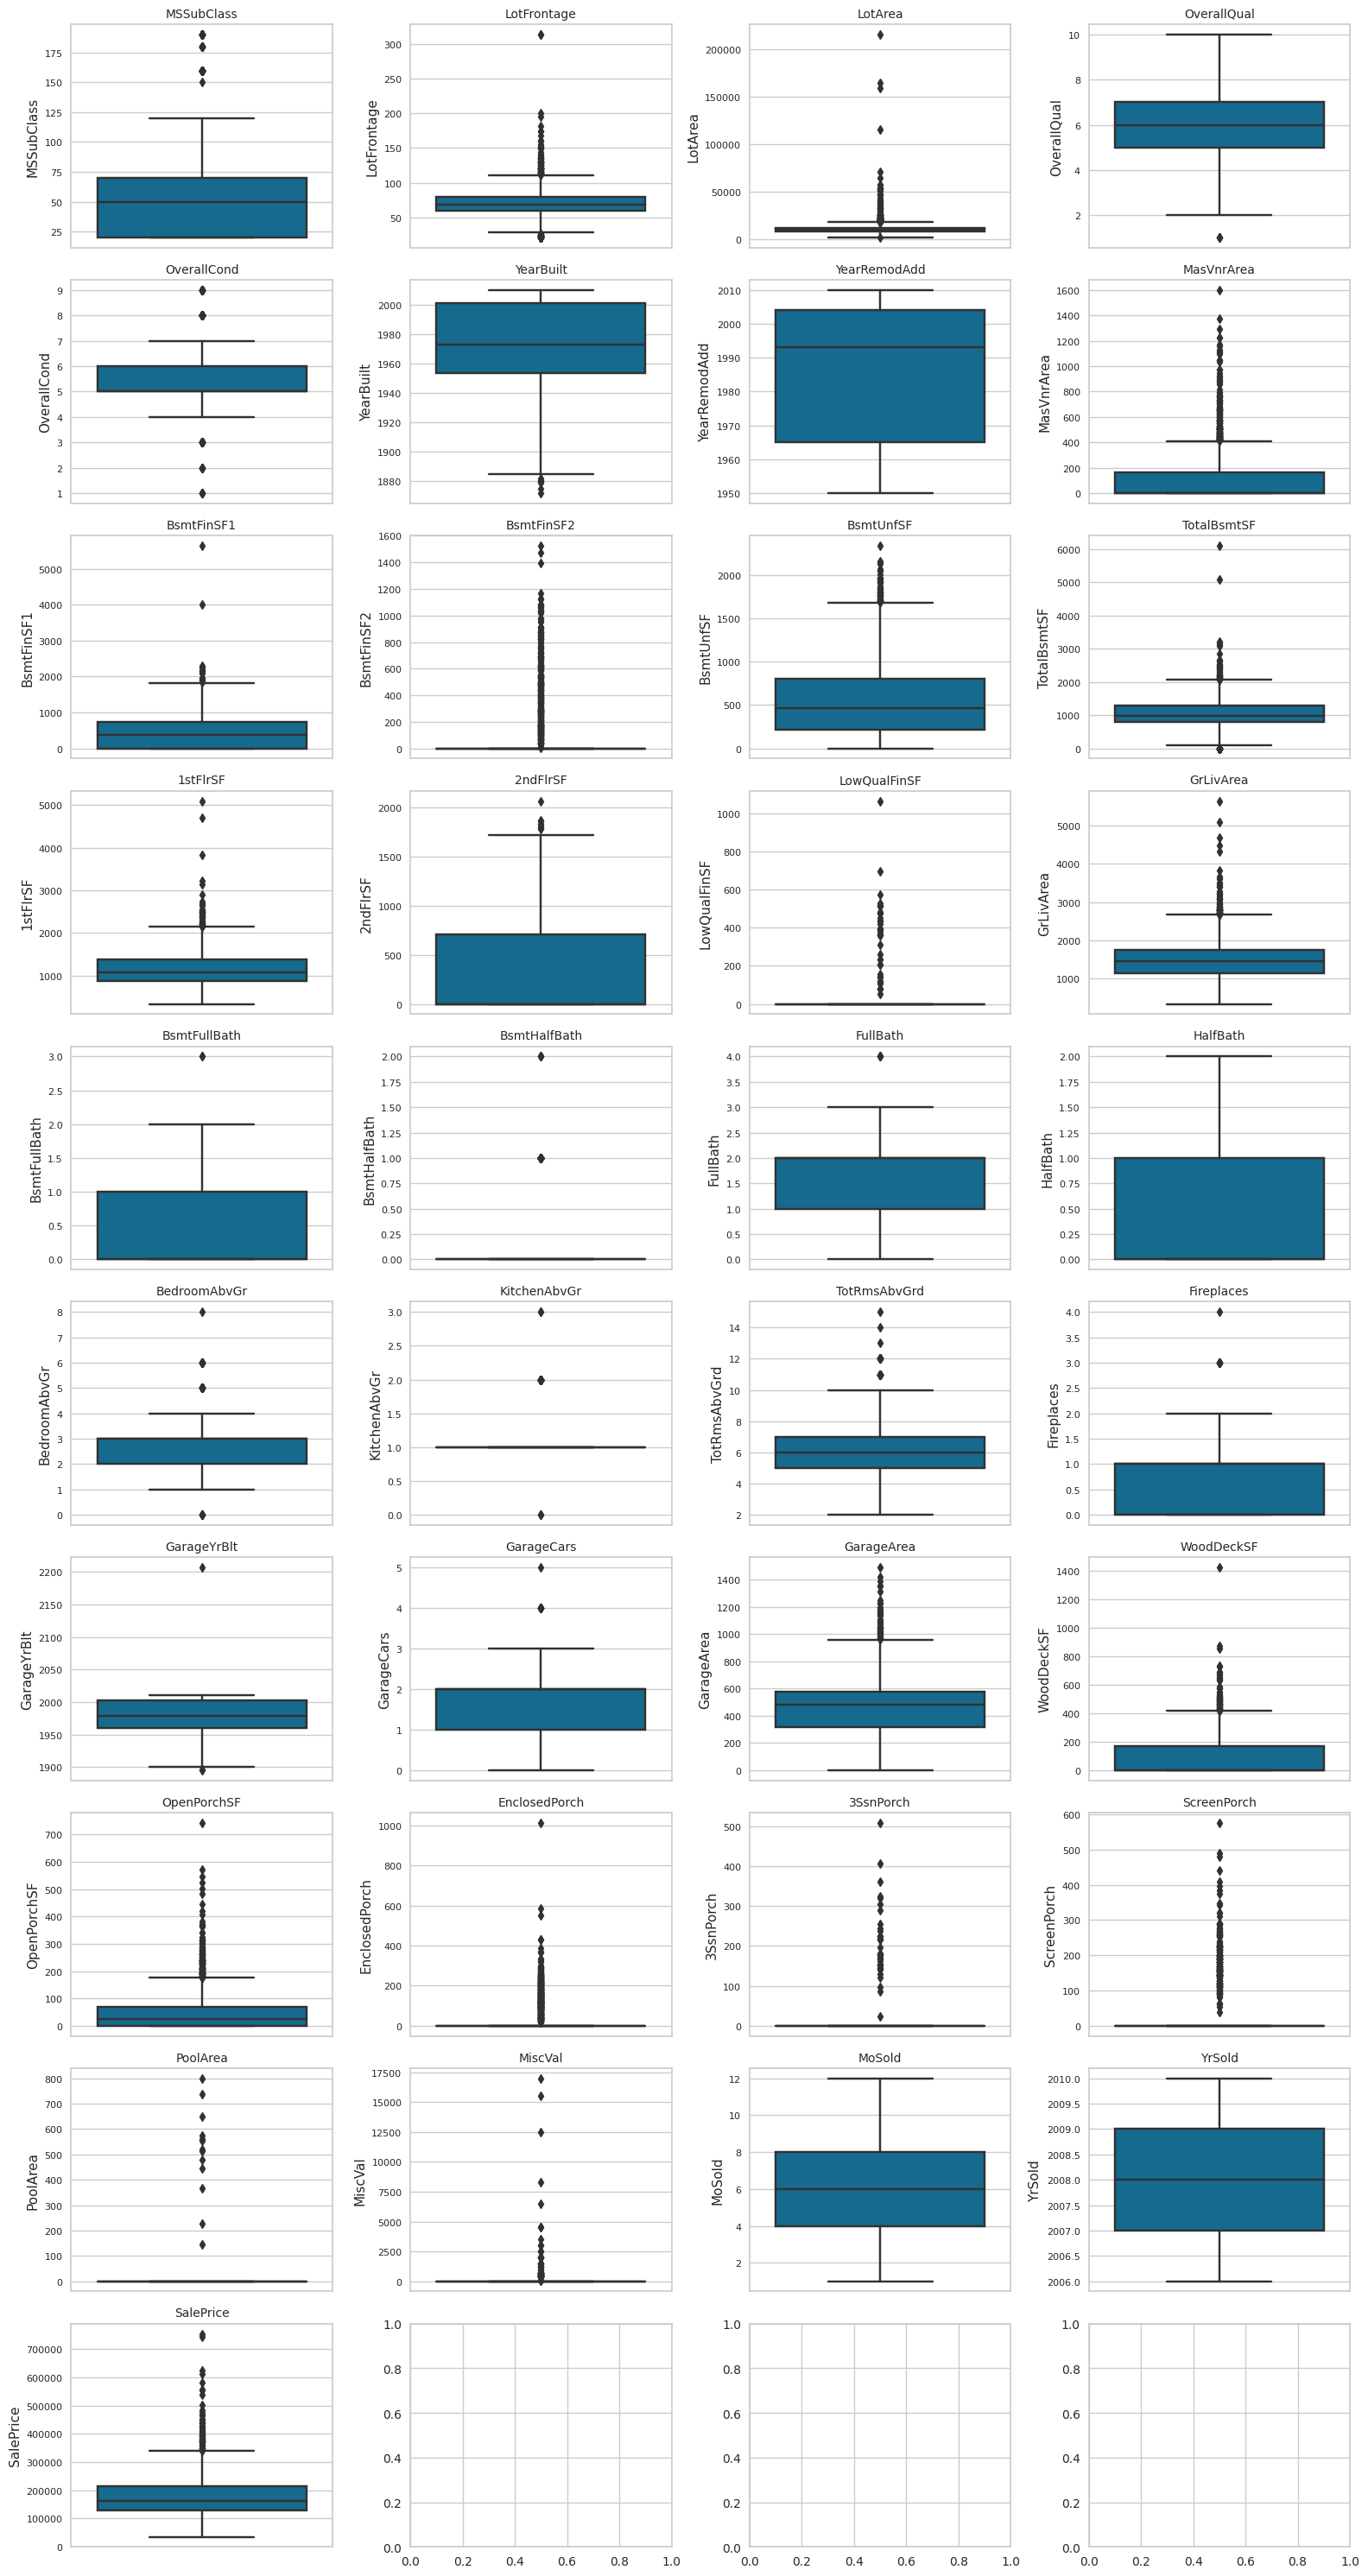

In [17]:
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 3 * num_rows))
axes = axes.flatten()[:num_cols]

for i, column in enumerate(df_combined_no_id.columns):
    sns.boxplot(df_combined_no_id, y=column, ax=axes[i])
    axes[i].set_title(column, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)


plt.tight_layout()
plt.show()

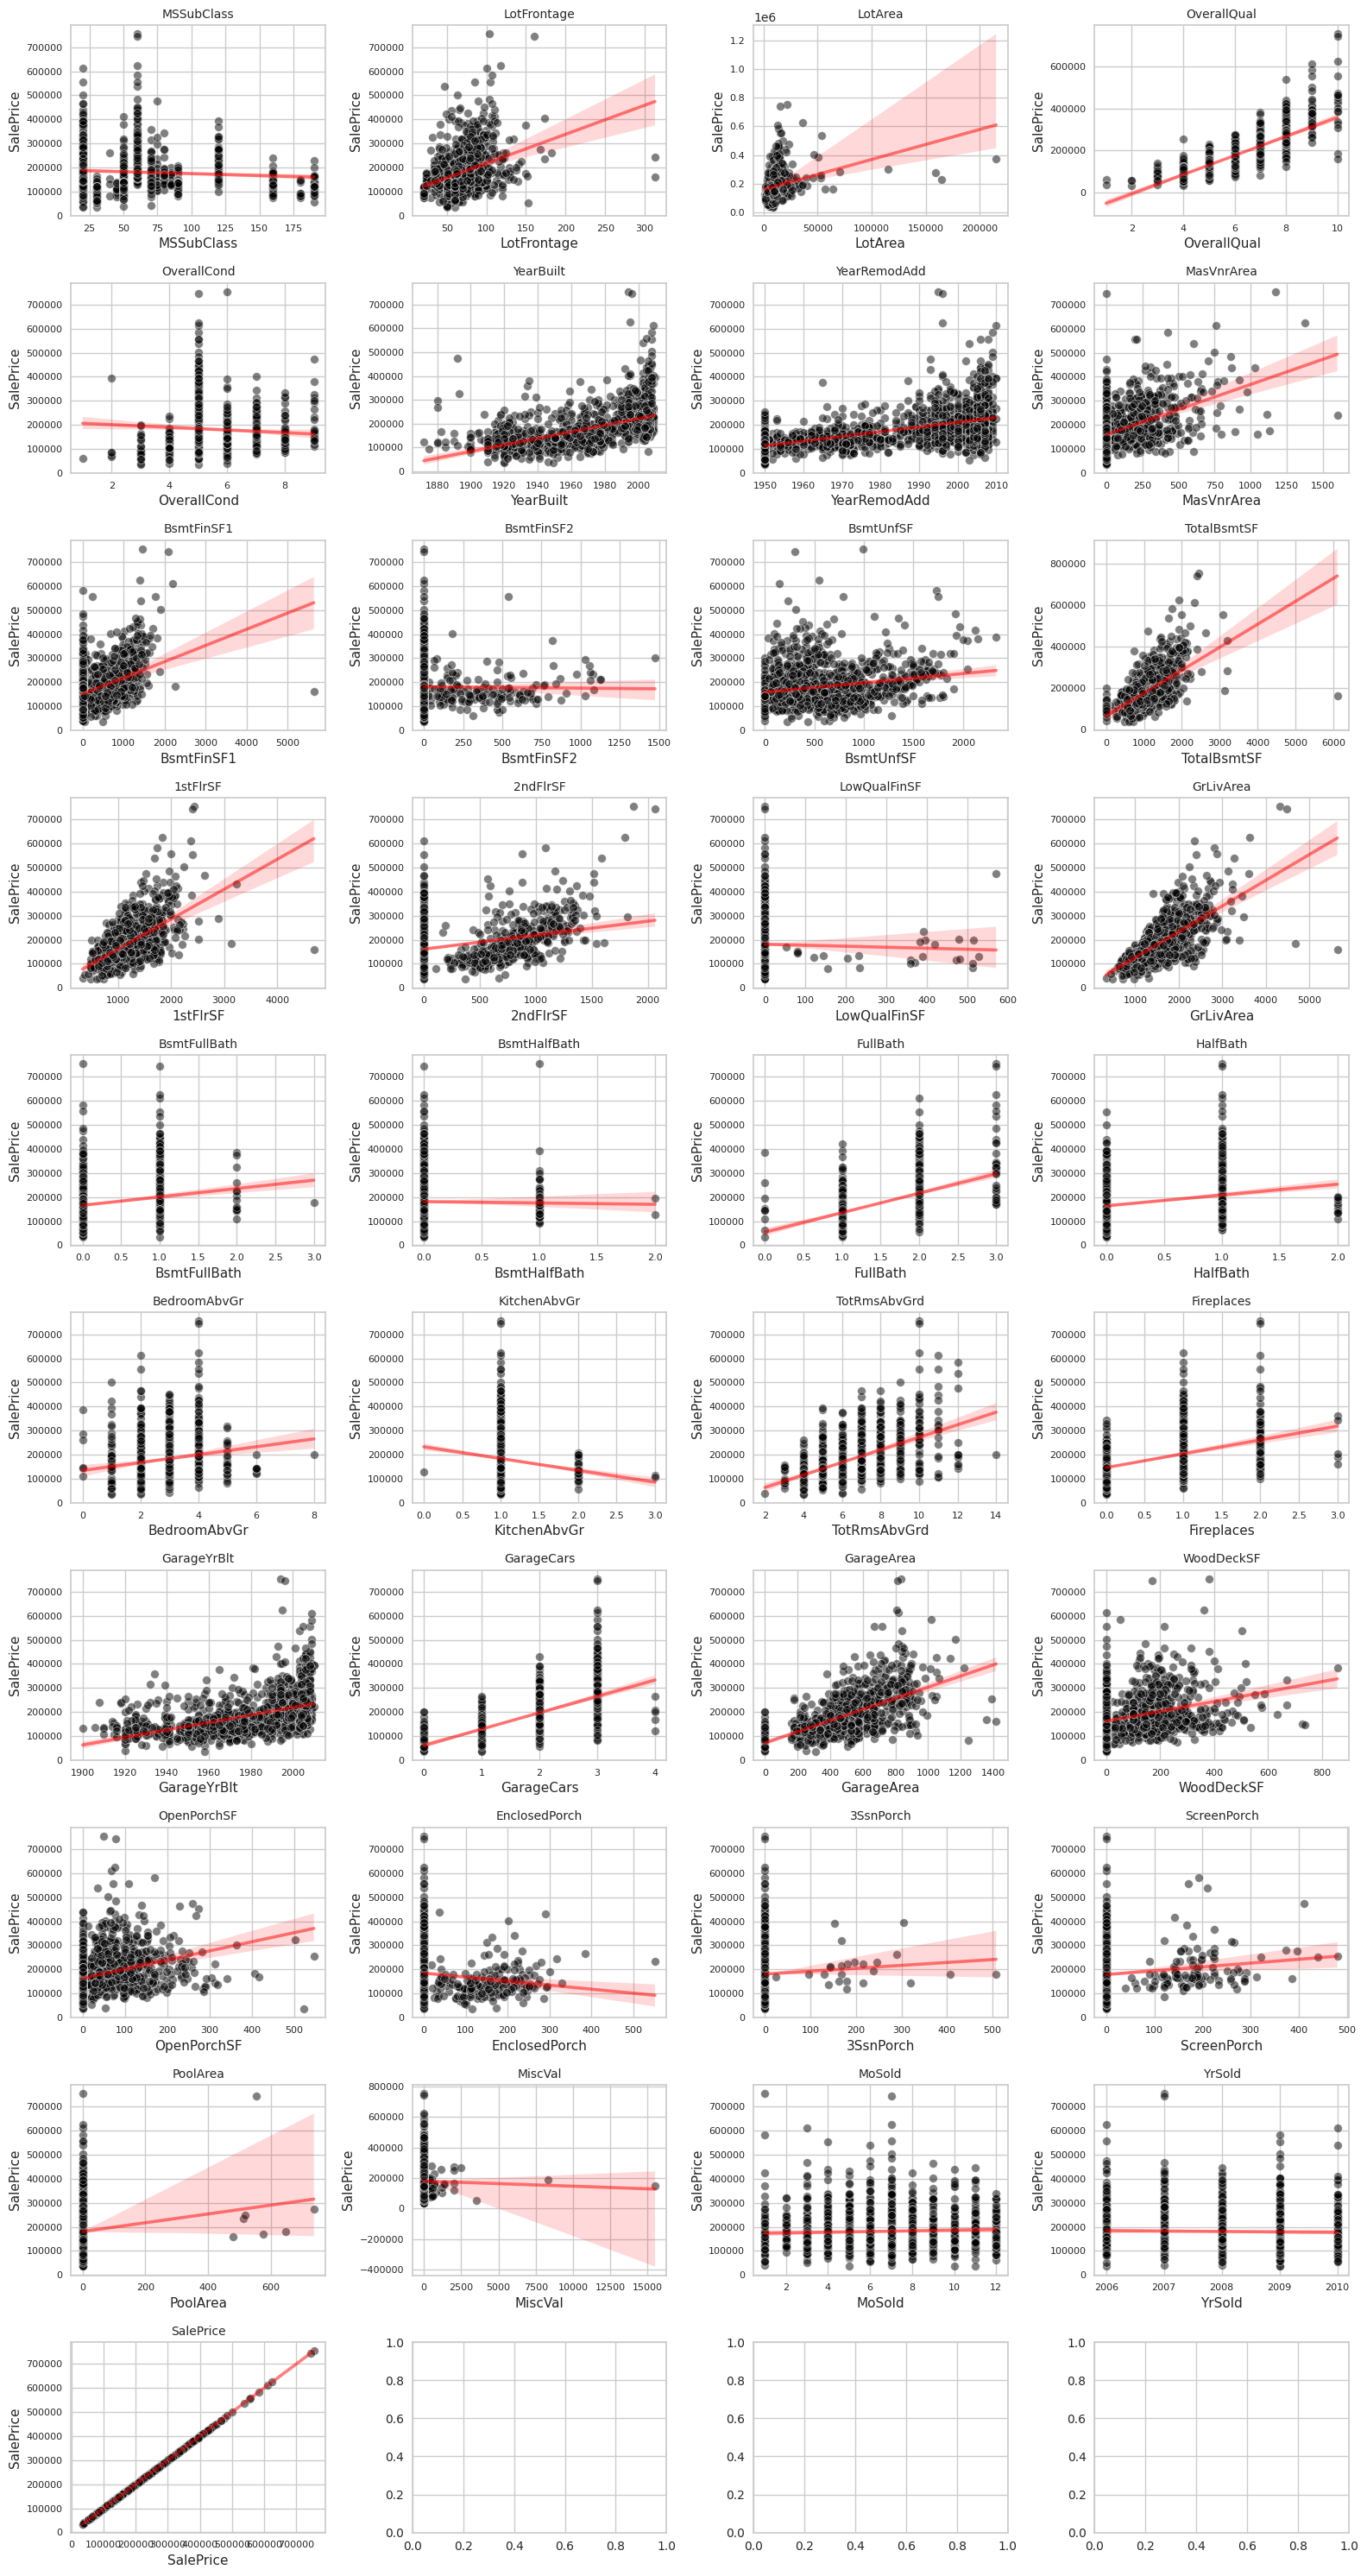

In [18]:
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 3 * num_rows))
axes = axes.flatten()[:num_cols]

# Iterate through each column and plot a scatterplot in relation to the target
for i, column in enumerate(df_combined_no_id.columns):
    ax = sns.scatterplot(data=df_combined_no_id, x=column, y='SalePrice', ax=axes[i], color='black', alpha=.5)
    sns.regplot(data=df_combined_no_id, x=column, y='SalePrice', line_kws = {"color": "red", "alpha": .5}, ci = 99, ax=ax, scatter=False) # 99% level 
    axes[i].set_title(column, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

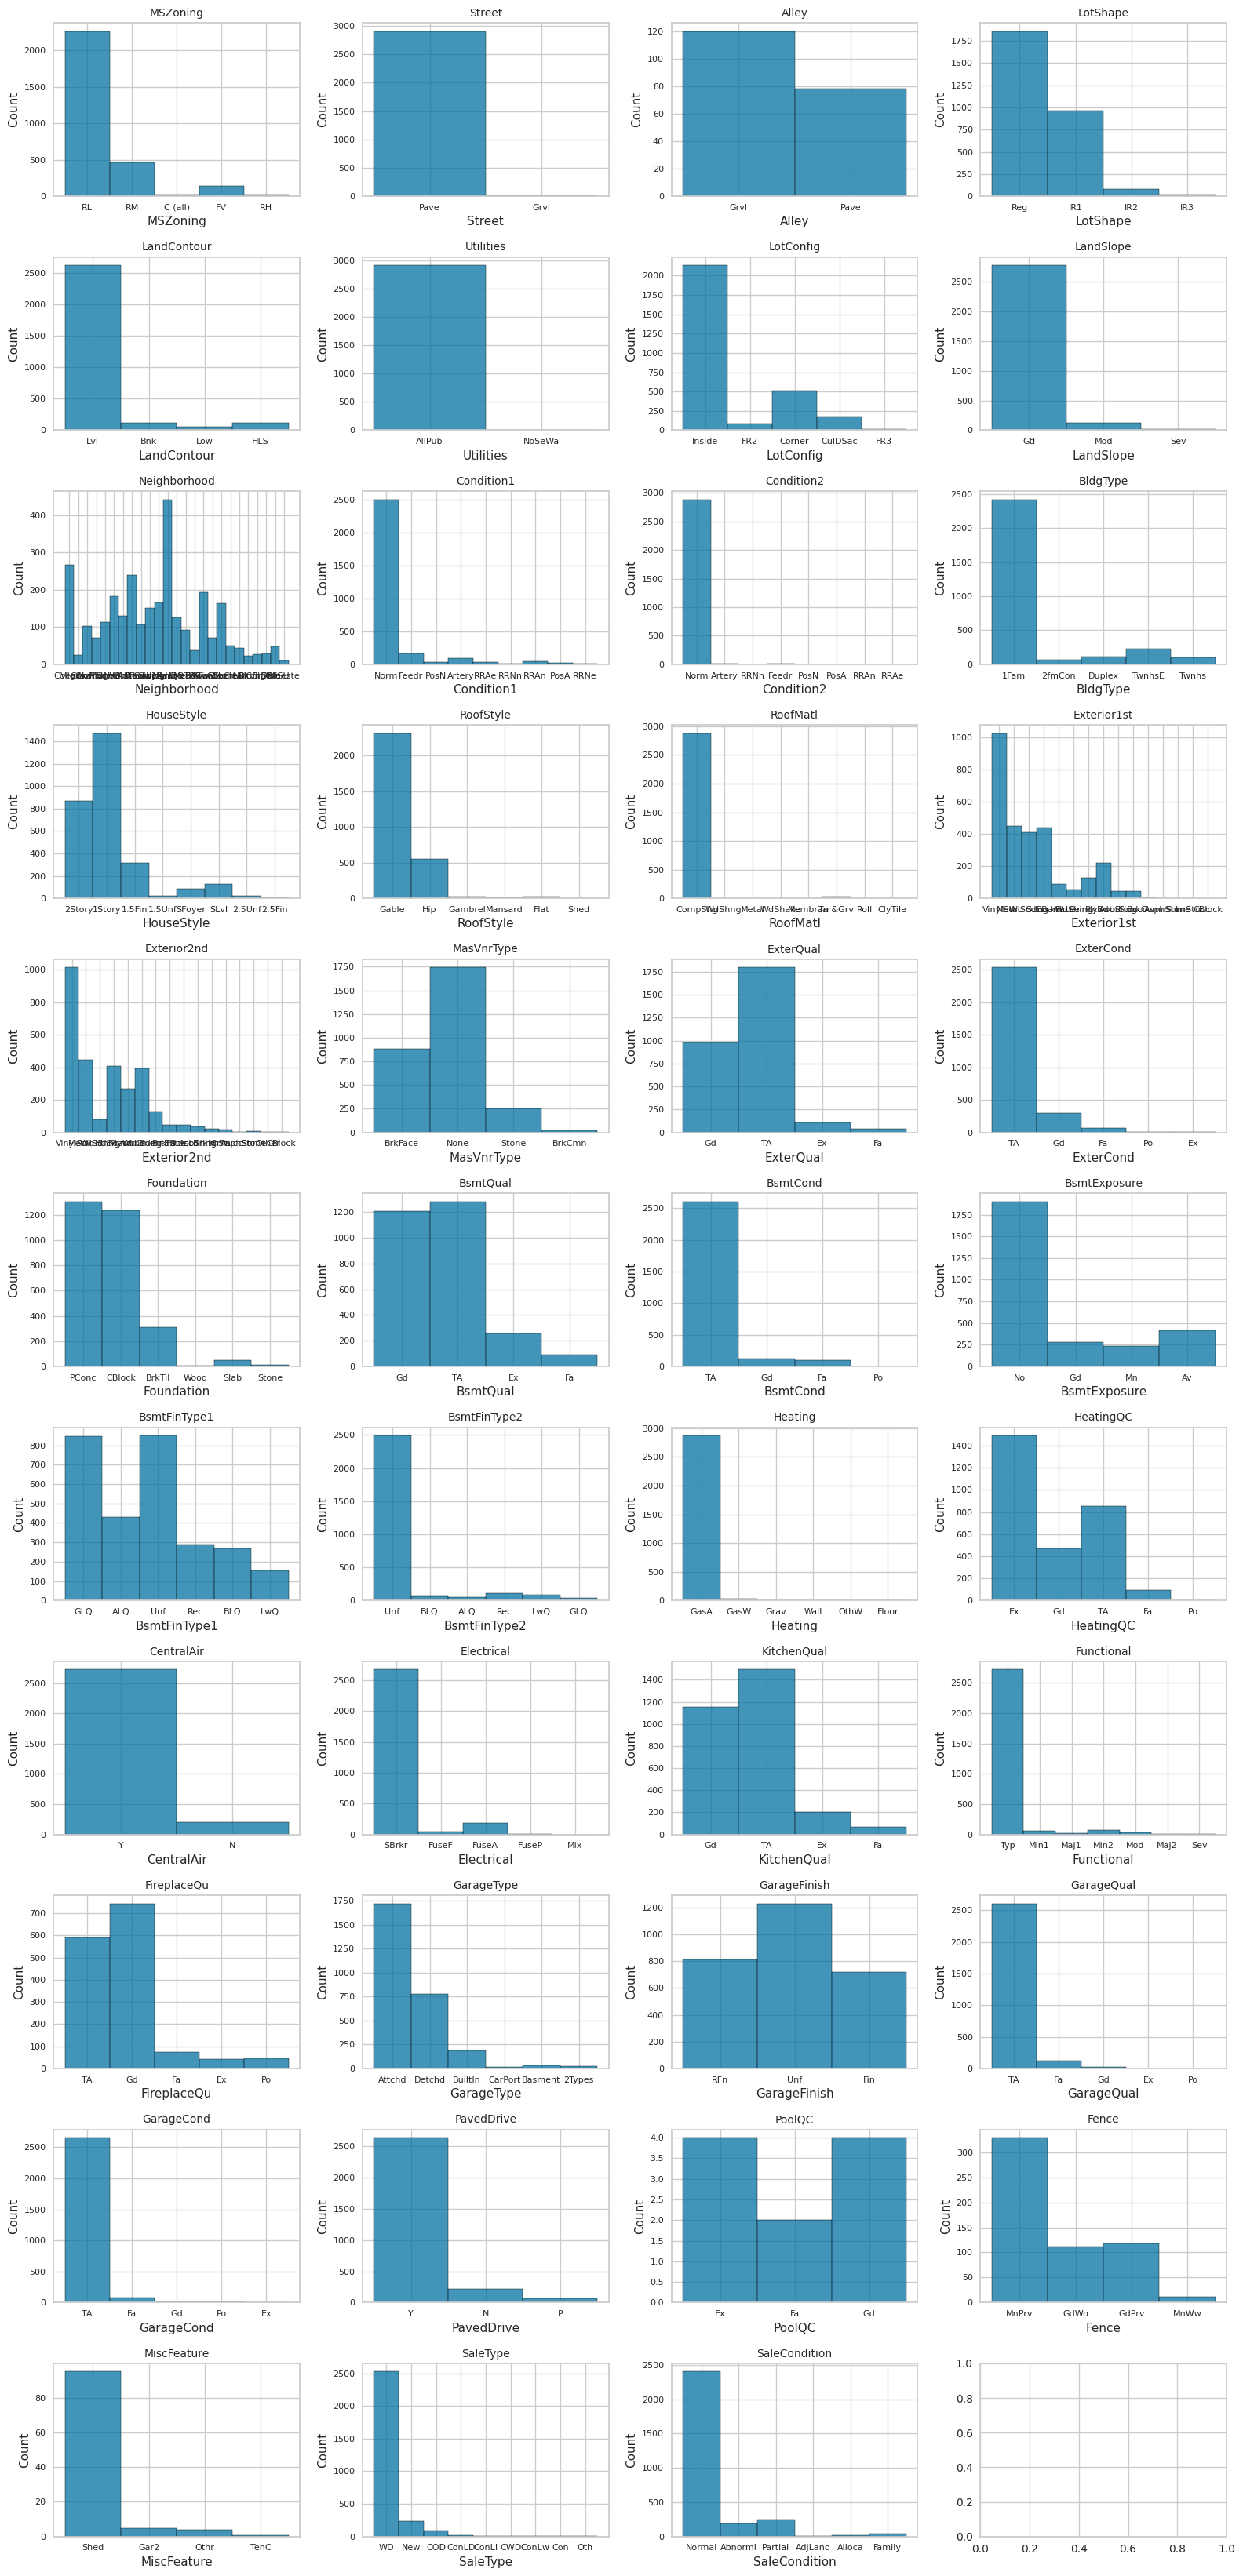

In [19]:
df_cat = df_combined[cat_selector(df_combined)]

# Calculate the number of rows and columns for subplots
num_cols = df_cat.shape[1]
num_rows = math.ceil(num_cols / 4)  # Adjust the divisor based on your layout preference

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 3 * num_rows))
axes = axes.flatten()[:num_cols]  # Flatten the 2D array of subplots and truncate to match the number of columns

# Iterate through each column and plot a histogram
# add a KDE and smooth it
for i, column in enumerate(df_cat.columns):
    sns.histplot(df_cat[column], bins=50, ax=axes[i])
    axes[i].set_title(column, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()


# 1. Data Preparation

## I. Id & Target dropping

In [20]:
# drop target from train data and ID from both data sets

df_train_target = df_train['SalePrice']
df_train_id = df_train['Id']

df_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)

df_test_id = df_test['Id']
df_test.drop(['Id'], axis=1, inplace=True)


## II. Data type identification & casting

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [23]:
# MSSubClass is categorical data

df_train['MSSubClass'] = df_train['MSSubClass'].astype('O')
df_test['MSSubClass'] = df_test['MSSubClass'].astype('O')

# 2. Preprocessing

## I. Handle missing data

### a) Categorical features

In [24]:
df_combined[na_features_categorical].head(5)

,MSZoning,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,RL,NaN,AllPub,VinylSd,VinylSd,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,NaN,NaN,NaN,WD
1,RL,NaN,AllPub,MetalSd,MetalSd,None,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,WD
2,RL,NaN,AllPub,VinylSd,VinylSd,BrkFace,Gd,TA,Mn,GLQ,Unf,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,WD
3,RL,NaN,AllPub,Wd Sdng,Wd Shng,None,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,NaN,NaN,NaN,WD
4,RL,NaN,AllPub,VinylSd,VinylSd,BrkFace,Gd,TA,Av,GLQ,Unf,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,WD


In [25]:
# data_description.txt implies that some columns have 'NA' as a valid value, i.e. Alley 'NA' = No alley access. 
# those columns need to be imputed appropriately 

features_valid = [
    'Alley',
    'MasVnrType',
    'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]

features_non_valid = [
    'Electrical',
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'KitchenQual',
    'Functional',
    'SaleType'
]

In [26]:
cat_none_imputer = ('cat_none_imputer', SimpleImputer(strategy='constant', fill_value='None'), features_valid)
cat_mode_imputer = ('cat_mode_imputer', SimpleImputer(strategy='most_frequent', fill_value=None), features_non_valid)

### b) Numerical features

In [27]:
# custom transformer, that checks if the condition_col and custom columns have NaN values at the same time
# i.e. when no basement was built, subsequently all columns regarding basements should be filled with NaN 

class FillMissingValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, condition_col, columns):
        self.condition_col = condition_col
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        filtered_rows = X[(X[self.condition_col].isna()) & X[self.columns].isna().any(axis=1)]
        X.loc[filtered_rows.index, self.columns] = X.loc[filtered_rows.index, self.columns].fillna(0)

        return X[self.columns]
    
    def set_output(self, *, transform=None):
        return self

In [28]:
# check if GarageQual (can take any garage related column from features_valid) is NaN, if so impute garage_cols with NaN

garage_cols = ['GarageCars', 'GarageArea']
garage_cond_col = 'GarageQual'

num_garage_custom_imputer = ('num_garage_custom_imputer', FillMissingValuesTransformer(garage_cond_col, garage_cols), garage_cols + [garage_cond_col])

In [29]:
# same as above, check if BsmtQual (can take any basement related column from features_valid) is NaN, if so impute basement_cols with NaN

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF']
basement_cond_col = 'BsmtQual'

num_basement_custom_imputer = ('num_basement_custom_imputer', FillMissingValuesTransformer(basement_cond_col, basement_cols), basement_cols + [basement_cond_col])

In [30]:
# fill with value of no significance, i.e. 1800
num_garage_year_imputer = ('num_garage_year_imputer', SimpleImputer(strategy='constant', fill_value=1800), ['GarageYrBlt'])

In [31]:
# impute remaining numerical columns with their median value

num_feats = [
    'LotFrontage',
    'MasVnrArea'
]

num_remaining_imputer = ('num_remaining_imputer', SimpleImputer(strategy='most_frequent', fill_value=None), num_feats)

In [32]:
# create ColumnTransformer object for all preprocessing steps

ct_imputation = ColumnTransformer([
        cat_none_imputer,
        cat_mode_imputer,
        num_garage_year_imputer,
        num_garage_custom_imputer,
        num_basement_custom_imputer,
        num_remaining_imputer
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# 3. Feature Engineering

## I. Transformation

In [33]:
# returns a list of skewed features.
# skeweness is calculated based on the Fisher-Pearson coefficient of skewness
# the threshold is 0.5

def get_skewed_features(X):
    skewed_features = []

    for feat in num_selector(X):
        val = abs(skew(X[feat]))
        if val >= .5:
            skewed_features.append(feat)
    return skewed_features

In [34]:
# create another transformer object to handle skeweness for skewed features by using PowerTransformer
p_transformer = PowerTransformer(standardize=False)

num_skew_transformer = ('num_skew_transformer', p_transformer, get_skewed_features)

ct_skew_transformation = ColumnTransformer([
        num_skew_transformer
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

### a) Target Transformation

In [35]:
# create pipeline to transform the target
p_transformer_target = PowerTransformer(standardize=False)

target_pipe = Pipeline([
    ('power_transform', p_transformer_target)    

])
target_pipe.set_output(transform='pandas')

target_reshaped = np.array(df_train_target).reshape(-1, 1)


## II. Encoding & Scaling

In [36]:
# transformer to one hot encode categorical features and normalize numerical features

ct_scale_and_ohe = ColumnTransformer([
        ("scale", StandardScaler(), num_selector),
        ("ohe", OneHotEncoder(dtype='int', handle_unknown='ignore', sparse_output=False), cat_selector)
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

## III. Create preprocessing pipeline

In [37]:
# create pipeline based on the ColumnTransformer objects
# first impute missing values, afterwards handle skewed features and finally normalize and one hot encode the data
# the output should be a pandas object

pipe = Pipeline([
    ("imputation", ct_imputation),
    ("skew_trans", ct_skew_transformation),
    ("scale_and_ohe", ct_scale_and_ohe),
])

pipe.set_output(transform='pandas')

Pipeline(steps=[('imputation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_none_imputer',
                                                  SimpleImputer(fill_value='None',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence', 'MiscFeature']),
                                                 (...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7829e9f3f220>),
                                                 ('ohe',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7829e9f3f6d0>)],
                                   verbose_feature_names_out=False))])

## IV. Perform preprocessing

In [38]:
X_train_clean = pipe.fit_transform(df_train)
X_test_clean = pipe.transform(df_test)

y_train_transformed = target_pipe.fit_transform(target_reshaped).rename(columns={'x0': 'SalePrice'})

# 4. Model Selection

In [39]:
s = setup(X_train_clean, target = y_train_transformed, session_id = 123, preprocess=True)

,Description,Value
0,Session id,123
1,Target,SaleCondition_Partial
2,Target type,Regression
3,Original data shape,"(1460, 316)"
4,Transformed data shape,"(1460, 316)"
5,Transformed train set shape,"(1021, 316)"
6,Transformed test set shape,"(439, 316)"
7,Numeric features,315
8,Preprocess,True
9,Imputation type,simple


In [40]:
#best = compare_models()

In [41]:
estimators = [
    ('gbr', GradientBoostingRegressor()),
    ('br', BayesianRidge()),
    ('lightgbm', LGBMRegressor()),
    ('omp', OrthogonalMatchingPursuit()),
    ('ridge', Ridge()),
    ('huber', HuberRegressor()),
]
final_estimator = CatBoostRegressor()

In [42]:
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=KFold(n_splits=6), 
    verbose=0
)

# 5. Model Training

In [43]:
reg.fit(X_train_clean, y_train_transformed)

Learning rate set to 0.043466
0:	learn: 0.1525249	total: 49.6ms	remaining: 49.6s
1:	learn: 0.1473298	total: 55.3ms	remaining: 27.6s
2:	learn: 0.1421579	total: 64.6ms	remaining: 21.5s
3:	learn: 0.1373544	total: 74.3ms	remaining: 18.5s
4:	learn: 0.1328342	total: 82.5ms	remaining: 16.4s
5:	learn: 0.1284128	total: 84.5ms	remaining: 14s
6:	learn: 0.1241084	total: 86.6ms	remaining: 12.3s
7:	learn: 0.1201124	total: 88.3ms	remaining: 11s
8:	learn: 0.1163116	total: 90.1ms	remaining: 9.92s
9:	learn: 0.1125347	total: 91.8ms	remaining: 9.09s
10:	learn: 0.1090653	total: 93.6ms	remaining: 8.42s
11:	learn: 0.1058243	total: 95.4ms	remaining: 7.85s
12:	learn: 0.1026461	total: 97.1ms	remaining: 7.37s
13:	learn: 0.0996720	total: 99.1ms	remaining: 6.98s
14:	learn: 0.0967262	total: 101ms	remaining: 6.63s
15:	learn: 0.0939409	total: 103ms	remaining: 6.32s
16:	learn: 0.0913801	total: 105ms	remaining: 6.05s
17:	learn: 0.0889113	total: 106ms	remaining: 5.8s
18:	learn: 0.0864659	total: 108ms	remaining: 5.59s
19

StackingRegressor(cv=KFold(n_splits=6, random_state=RandomState(MT19937) at 0x7829DFCA7D40,
   shuffle=False),
                  estimators=[('gbr', GradientBoostingRegressor()),
                              ('br', BayesianRidge()),
                              ('lightgbm', LGBMRegressor()),
                              ('omp', OrthogonalMatchingPursuit()),
                              ('ridge', Ridge()), ('huber', HuberRegressor())],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x7829f47df640>)

# 6. Model Evaluation

In [44]:
predicted = reg.predict(X_test_clean)
prediction_reshaped = np.reshape(predicted, (-1,1))

reg_prediction = p_transformer_target.inverse_transform(prediction_reshaped)
reg_prediction

array([[118644.30637173],
       [151225.20873839],
       [182024.34605235],
       ...,
       [166308.50917691],
       [120416.59075973],
       [230773.17776532]])

# 7. Model Submission

In [45]:
reg_submission = pd.DataFrame({'Id': df_test_id, 'SalePrice': np.reshape(reg_prediction, (-1,))})
reg_submission.head()

,Id,SalePrice
0,1461,118644.306372
1,1462,151225.208738
2,1463,182024.346052
3,1464,192537.213247
4,1465,191696.972771


In [46]:
reg_submission.to_csv("./reg_submission.csv", index=False)